In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

import warnings

warnings.filterwarnings('ignore',category= DeprecationWarning)
np.random.seed(7)

In [3]:
path = Path('data')/'Anime_rec'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('data/Anime_rec')

In [4]:
#! kaggle datasets download -d CooperUnion/anime-recommendations-database -p {path}
#! unzip {path}/anime-recommendations-database.zip -d {path}

In [5]:
ratings = pd.read_csv(path/'rating.csv')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
anime = pd.read_csv(path/'anime.csv')
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [7]:
df = ratings.merge(anime[['anime_id', 'name']])
df.head()

,user_id,anime_id,rating,name
0,1,20,-1,Naruto
1,3,20,8,Naruto
2,5,20,6,Naruto
3,6,20,-1,Naruto
4,10,20,-1,Naruto


In [8]:
user = 'user_id'
item = 'name'
rating = 'rating'

In [9]:
df.rating.value_counts()

 8     1646019
-1     1476488
 7     1375287
 9     1254094
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: rating, dtype: int64

Unrated anime = -1

In [10]:
len(df.index)

7813727

In [11]:
df = df[(df.rating != -1)]
len(df.index)

6337239

In [12]:
g = df.groupby('name')['rating'].count()
num_rated = g.sort_values(ascending=True)
less_rated = list(num_rated[num_rated<10].index.values) 
len(less_rated)

2561

In [13]:
df = df[~df['name'].isin(less_rated)]
len(df)

6328961

In [14]:
data = (CollabList.from_df(df, cat_names=[user, item], procs=Categorify)
       .random_split_by_pct(0.1, seed=7)
       .label_from_df(rating)
       .databunch())

In [15]:
data.show_batch()

user_id,name,target
55433,Kyoukai no Kanata,6.0
22578,Hagure Yuusha no Aesthetica,7.0
72316,Corpse Party: Tortured Souls - Bougyakusareta Tamashii no Jukyou,7.0
7278,Sekirei: Hajimete no Otsukai,8.0
2487,Elfen Lied,8.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


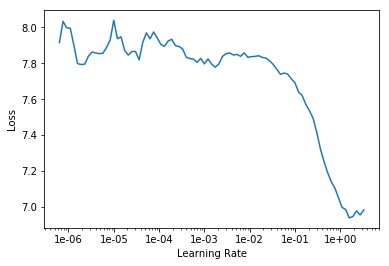

In [16]:
learn = collab_learner(data, n_factors = 20, y_range = [0,11])
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(4, 1e-1)

epoch,train_loss,valid_loss
1,14.860605,14.891272
2,13.455354,13.414622
3,4.146457,4.141950
4,1.446013,1.485025


In [18]:
learn.save('4epochs-lr0.1-20factors')

In [ ]:
learn.load('4epochs-lr0.1-20factors')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


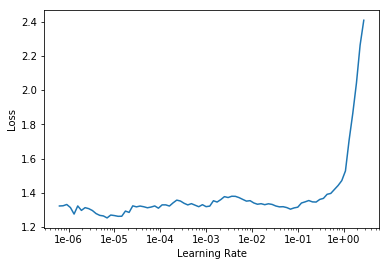

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2, 3e-6)

epoch,train_loss,valid_loss
1,1.377854,1.483736
2,1.402600,1.483063


In [26]:
learn.save('4,2epochs-lr0.1,3e-6-20factors')

In [27]:
learn.load('4,2epochs-lr0.1,3e-6-20factors')

CollabLearner(data=TabularDataBunch;

Train: LabelList
y: FloatList (5696065 items)
[FloatItem 8.0, FloatItem 6.0, FloatItem 8.0, FloatItem 9.0, FloatItem 9.0]...
Path: .
x: CollabList (5696065 items)
[CollabLine user_id 3; name Naruto; , CollabLine user_id 5; name Naruto; , CollabLine user_id 21; name Naruto; , CollabLine user_id 28; name Naruto; , CollabLine user_id 34; name Naruto; ]...
Path: .;

Valid: LabelList
y: FloatList (632896 items)
[FloatItem 7.0, FloatItem 9.0, FloatItem 7.0, FloatItem 9.0, FloatItem 9.0]...
Path: .
x: CollabList (632896 items)
[CollabLine user_id 37754; name Black Lagoon: The Second Barrage; , CollabLine user_id 16817; name Toradora!; , CollabLine user_id 8236; name Ookami-san to Shichinin no Nakama-tachi; , CollabLine user_id 5175; name Kara no Kyoukai 1: Fukan Fuukei; , CollabLine user_id 32758; name Ladies versus Butlers!; ]...
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(69244, 20)
  (i_weight): Embedding(7366, 20)
  (u_bias):

## Interpretation

### Setup

In [28]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(69244, 20)
  (i_weight): Embedding(7366, 20)
  (u_bias): Embedding(69244, 1)
  (i_bias): Embedding(7366, 1)
)

Select the top 1000 most rated animes

In [29]:
rating_count = df.groupby('name')['rating'].count()
most_rated = rating_count.sort_values(ascending=False).index.values[:1000]
most_rated[:10]

array(['Death Note', 'Sword Art Online', 'Shingeki no Kyojin', 'Code Geass: Hangyaku no Lelouch', 'Angel Beats!',
       'Elfen Lied', 'Naruto', 'Fullmetal Alchemist: Brotherhood', 'Fullmetal Alchemist',
       'Code Geass: Hangyaku no Lelouch R2'], dtype=object)

### Bias

In [30]:
anime_bias = learn.bias(most_rated, is_item=True)
anime_bias.shape

torch.Size([1000])

Get mean ratings of each anime

In [31]:
mean_ratings = df.groupby('name')['rating'].mean()
mean_ratings.sort_values(ascending=False)

name
Gintama°                                                     9.449495
Kimi no Na wa.                                               9.426313
Ginga Eiyuu Densetsu                                         9.389788
Fullmetal Alchemist: Brotherhood                             9.322741
Gintama&#039;                                                9.272552
Steins;Gate                                                  9.261326
Gintama                                                      9.236398
Hunter x Hunter (2011)                                       9.234586
Gintama&#039;: Enchousen                                     9.202258
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare          9.191430
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou    9.171484
Clannad: After Story                                         9.165292
Code Geass: Hangyaku no Lelouch R2                           9.059837
Koe no Katachi                                               9.029412
Shigatsu wa Kim

Compare with anime bias learned

In [32]:
anime_ratings = [(b,i,mean_ratings.loc[i]) for i,b in zip(most_rated,anime_bias)]
sorting_key = lambda o:o[0] 

Best anime according to learned bias

In [33]:
sorted(anime_ratings, key = sorting_key, reverse = True)[:15]

[(tensor(1.6794), 'Kimi no Na wa.', 9.426313105558389),
 (tensor(1.6645), 'Fullmetal Alchemist: Brotherhood', 9.32274123011073),
 (tensor(1.6548), 'Steins;Gate', 9.26132587021165),
 (tensor(1.6197), 'Hunter x Hunter (2011)', 9.234586063929383),
 (tensor(1.6172), 'Gintama&#039;', 9.27255216693419),
 (tensor(1.6004), 'Gintama', 9.23639774859287),
 (tensor(1.5779), 'Gintama&#039;: Enchousen', 9.202257761053621),
 (tensor(1.5732),
  'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare',
  9.191429902189101),
 (tensor(1.5287), 'Clannad: After Story', 9.165291919061735),
 (tensor(1.4714), 'Code Geass: Hangyaku no Lelouch R2', 9.059837152054536),
 (tensor(1.4329), 'Shigatsu wa Kimi no Uso', 8.984040623866521),
 (tensor(1.4060), 'Tengen Toppa Gurren Lagann', 8.93317605426128),
 (tensor(1.4036), 'One Punch Man', 8.939680296741146),
 (tensor(1.4016), 'Code Geass: Hangyaku no Lelouch', 8.927795739036723),
 (tensor(1.3989), 'Ookami Kodomo no Ame to Yuki', 8.932257091128546)]

Worst anime according to bias learned

In [34]:
sorted(anime_ratings, key = sorting_key)[:15]

[(tensor(-0.5129), 'Pupa', 4.217798594847775),
 (tensor(-0.1027), 'Boku no Pico', 5.351654514862591),
 (tensor(0.0283), 'Glasslip', 5.818694222639737),
 (tensor(0.0569), 'Diabolik Lovers', 6.121327737504769),
 (tensor(0.1261), 'Mayoiga', 6.044811320754717),
 (tensor(0.1760), 'Mahou Sensou', 6.424483882651213),
 (tensor(0.1935), 'Amnesia', 6.637989778534924),
 (tensor(0.2141),
  'Oniichan no Koto nanka Zenzen Suki ja Nai n da kara ne!!',
  6.5617728531855954),
 (tensor(0.2282),
  'Dragon Ball Z Movie 11: Super Senshi Gekiha!! Katsu no wa Ore da',
  6.334947183098592),
 (tensor(0.2402), 'Akikan!', 6.63254113345521),
 (tensor(0.2451), 'Arcana Famiglia', 6.600066489361702),
 (tensor(0.2463), 'Aki-Sora', 6.553664302600473),
 (tensor(0.2483),
  'Naruto: Akaki Yotsuba no Clover wo Sagase',
  6.643518518518518),
 (tensor(0.2539),
  'Saikin, Imouto no Yousu ga Chotto Okashiinda ga.',
  6.674318507890962),
 (tensor(0.2628), 'Corpse Party: Missing Footage', 6.468678815489749)]

### Weights

In [35]:
anime_weights = learn.weight(most_rated, is_item=True)
anime_weights.shape

torch.Size([1000, 20])

In [37]:
anime_pca = anime_weights.pca(k=3)
anime_pca.shape

torch.Size([1000, 3])

In [38]:
fac0, fac1, fac2 = anime_pca.t() 

In [40]:
most_rated

array(['Death Note', 'Sword Art Online', 'Shingeki no Kyojin', 'Code Geass: Hangyaku no Lelouch', ...,
       'Gakusen Toshi Asterisk 2nd Season', 'One Piece Movie 5: Norowareta Seiken', 'Michiko to Hatchin',
       'Murder Princess'], dtype=object)

In [59]:
fac0_represent = [(f,i) for f,i in zip(fac0, most_rated)]
sorted(fac0_represent, key = sorting_key, reverse = True)[:15]

[(tensor(1.0465), 'Yojouhan Shinwa Taikei'),
 (tensor(1.0262), 'Sennen Joyuu'),
 (tensor(0.9764), 'Cowboy Bebop'),
 (tensor(0.9209), 'Ghost in the Shell: Stand Alone Complex 2nd GIG'),
 (tensor(0.9131), 'Kara no Kyoukai 5: Mujun Rasen'),
 (tensor(0.9068), 'Perfect Blue'),
 (tensor(0.8979), 'Serial Experiments Lain'),
 (tensor(0.8887), 'Hachimitsu to Clover II'),
 (tensor(0.8834), 'Mushishi'),
 (tensor(0.8709), 'Neon Genesis Evangelion: The End of Evangelion'),
 (tensor(0.8597), 'Kino no Tabi: The Beautiful World'),
 (tensor(0.8476), 'Monster'),
 (tensor(0.8418), 'Ghost in the Shell'),
 (tensor(0.8387), 'Ping Pong The Animation'),
 (tensor(0.8369), 'Mawaru Penguindrum')]

In [60]:
sorted(fac0_represent, key = sorting_key)[:15]

[(tensor(-1.0095), 'Sword Art Online'),
 (tensor(-0.8705), 'Diabolik Lovers'),
 (tensor(-0.7862),
  'Naruto Movie 3: Dai Koufun! Mikazuki Jima no Animaru Panikku Dattebayo!'),
 (tensor(-0.7651), 'IS: Infinite Stratos 2'),
 (tensor(-0.7642), 'Highschool of the Dead: Drifters of the Dead'),
 (tensor(-0.7569), 'Rosario to Vampire Capu2'),
 (tensor(-0.7359), 'Zero no Tsukaima: Princesses no Rondo'),
 (tensor(-0.7326), 'Absolute Duo'),
 (tensor(-0.7252), 'Fairy Tail'),
 (tensor(-0.7247), 'High School DxD'),
 (tensor(-0.7245), 'Maken-Ki!'),
 (tensor(-0.7038), 'Omamori Himari'),
 (tensor(-0.7028), 'High School DxD New'),
 (tensor(-0.7021), 'IS: Infinite Stratos'),
 (tensor(-0.6919), 'Rosario to Vampire')]

In [61]:
fac1_represent = [(f,i) for f,i in zip(fac1, most_rated)]
sorted(fac1_represent, key = sorting_key, reverse = True)[:15]

[(tensor(0.6048),
  'Dragon Ball Z Movie 06: Gekitotsu!! 100-oku Power no Senshi-tachi'),
 (tensor(0.6014),
  'Dragon Ball Z Movie 09: Ginga Girigiri!! Bucchigiri no Sugoi Yatsu'),
 (tensor(0.5947), 'Pokemon: Kesshoutou no Teiou Entei'),
 (tensor(0.5876), 'Dragon Ball Z Movie 01: Ora no Gohan wo Kaese!!'),
 (tensor(0.5618),
  'Dragon Ball Z Movie 07: Kyokugen Battle!! Sandai Super Saiyajin'),
 (tensor(0.5462),
  'Dragon Ball Z Special 2: Zetsubou e no Hankou!! Nokosareta Chousenshi - Gohan to Trunks'),
 (tensor(0.5338), 'Pokemon Advanced Generation'),
 (tensor(0.5234), 'Pokemon: Mewtwo! Ware wa Koko ni Ari'),
 (tensor(0.5208),
  'Dragon Ball Z Movie 12: Fukkatsu no Fusion!! Gokuu to Vegeta'),
 (tensor(0.5006), 'Dragon Ball Z Movie 04: Super Saiyajin da Son Gokuu'),
 (tensor(0.4792), 'Dragon Ball Z Movie 03: Chikyuu Marugoto Choukessen'),
 (tensor(0.4715), 'Dragon Ball Z Special 1: Tatta Hitori no Saishuu Kessen'),
 (tensor(0.4549), 'Dragon Ball Z Movie 05: Tobikkiri no Saikyou tai Saik

In [62]:
sorted(fac1_represent, key = sorting_key)[:15]

[(tensor(-0.4781), 'Shakugan no Shana'),
 (tensor(-0.4522), 'Goshuushou-sama Ninomiya-kun'),
 (tensor(-0.4509), 'Kiniro no Corda: Primo Passo'),
 (tensor(-0.4426), 'Zero no Tsukaima'),
 (tensor(-0.4322), 'Shakugan no Shana II (Second)'),
 (tensor(-0.4031), 'Lucky☆Star'),
 (tensor(-0.4002), 'Kanon (2006)'),
 (tensor(-0.3972), 'Suzumiya Haruhi no Yuuutsu'),
 (tensor(-0.3969), 'Love Hina Christmas Special: Silent Eve'),
 (tensor(-0.3889), 'Onegai☆Teacher: Himitsu na Futari'),
 (tensor(-0.3833), 'School Rumble'),
 (tensor(-0.3799), 'Shuffle!'),
 (tensor(-0.3771), 'Vampire Knight Guilty'),
 (tensor(-0.3546), 'Zero no Tsukaima: Princesses no Rondo'),
 (tensor(-0.3527), 'Akaneiro ni Somaru Saka')]

In [63]:
fac2_represent = [(f,i) for f,i in zip(fac2, most_rated)]
sorted(fac2_represent, key = sorting_key, reverse = True)[:15]

[(tensor(0.6155), 'Dragon Ball Z Movie 01: Ora no Gohan wo Kaese!!'),
 (tensor(0.6074), 'Dragon Ball Z Movie 03: Chikyuu Marugoto Choukessen'),
 (tensor(0.5878), 'Dragon Ball Z Movie 02: Kono Yo de Ichiban Tsuyoi Yatsu'),
 (tensor(0.5139), 'Dragon Ball Z Movie 05: Tobikkiri no Saikyou tai Saikyou'),
 (tensor(0.4996),
  'Dragon Ball Z Movie 09: Ginga Girigiri!! Bucchigiri no Sugoi Yatsu'),
 (tensor(0.4978), 'InuYasha: Tenka Hadou no Ken'),
 (tensor(0.4854),
  'Dragon Ball Z Movie 06: Gekitotsu!! 100-oku Power no Senshi-tachi'),
 (tensor(0.4845), 'InuYasha: Toki wo Koeru Omoi'),
 (tensor(0.4756), 'Dragon Ball Z Movie 04: Super Saiyajin da Son Gokuu'),
 (tensor(0.4727),
  'Dragon Ball Z Movie 13: Ryuuken Bakuhatsu!! Goku ga Yaraneba Dare ga Yaru'),
 (tensor(0.4716), 'One Piece Movie 1'),
 (tensor(0.4594), 'Bishoujo Senshi Sailor Moon S'),
 (tensor(0.4569),
  'Dragon Ball Z Movie 08: Moetsukiro!! Nessen, Ressen, Chougekisen'),
 (tensor(0.4522), 'One Piece Movie 4: Dead End no Bouken'),
 (t

In [64]:
sorted(fac2_represent, key = sorting_key)[:15]

[(tensor(-0.4298), 'Charlotte'),
 (tensor(-0.3631), 'Hibike! Euphonium'),
 (tensor(-0.3595), 'Aldnoah.Zero 2nd Season'),
 (tensor(-0.3513), 'Little Busters!: Refrain'),
 (tensor(-0.3455), 'Zankyou no Terror'),
 (tensor(-0.3336), 'Clannad: After Story'),
 (tensor(-0.3289), 'Fate/stay night: Unlimited Blade Works 2nd Season'),
 (tensor(-0.3248), 'Owari no Seraph: Nagoya Kessen-hen'),
 (tensor(-0.3224), 'Kami nomi zo Shiru Sekai: Megami-hen'),
 (tensor(-0.3195), 'Durarara!!x2 Ketsu'),
 (tensor(-0.3118), 'Black Bullet'),
 (tensor(-0.3108), 'Owari no Seraph'),
 (tensor(-0.3022), 'Fate/stay night: Unlimited Blade Works'),
 (tensor(-0.2915), 'Shokugeki no Souma: Ni no Sara'),
 (tensor(-0.2887), 'Akuma no Riddle')]

In [120]:
def plot_relation(f0,f1, title):
    idx = np.linspace(0,980,50).astype(int)
    X = f0[idx]
    Y = f1[idx]
    plt.figure(figsize=(15,15))
    plt.title(title)
    plt.scatter(X,Y)
    for i, x, y in zip(most_rated[idx], X, Y):
        plt.text(x,y,i, fontsize = 10)
    plt.show()    

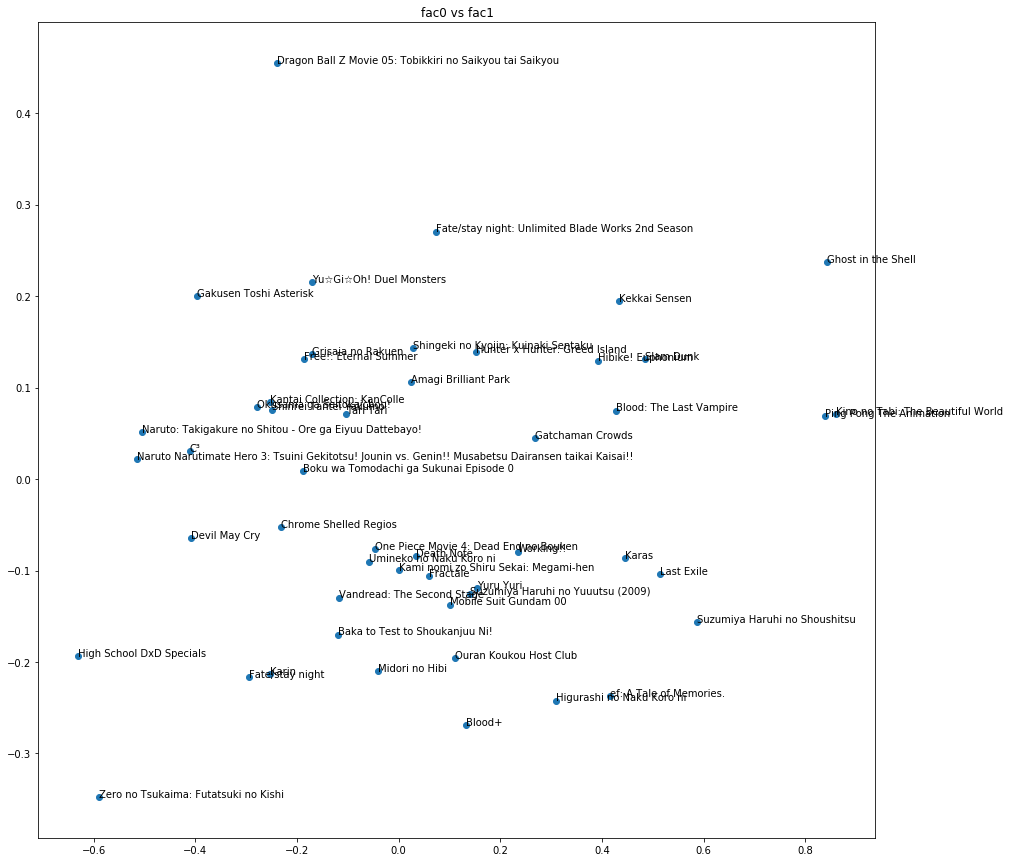

In [121]:
plot_relation(fac0, fac1, 'fac0 vs fac1')

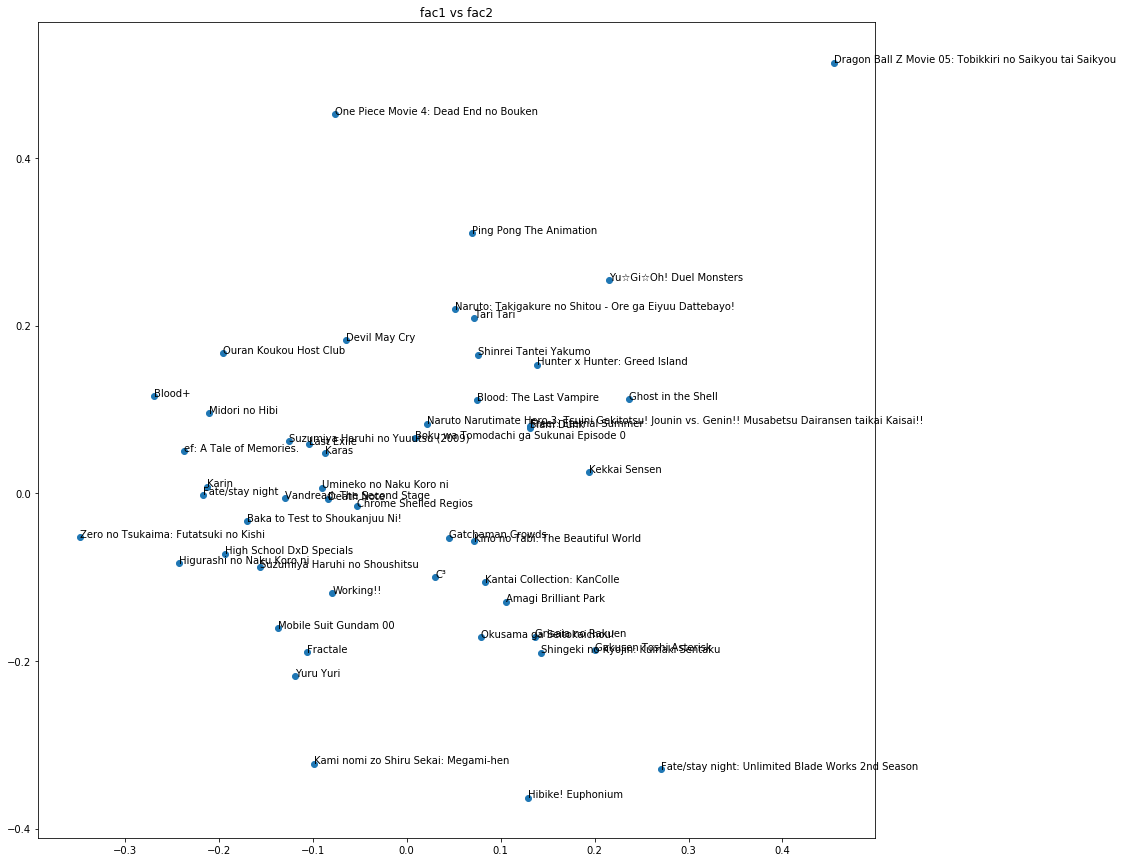

In [122]:
plot_relation(fac1, fac2, 'fac1 vs fac2')

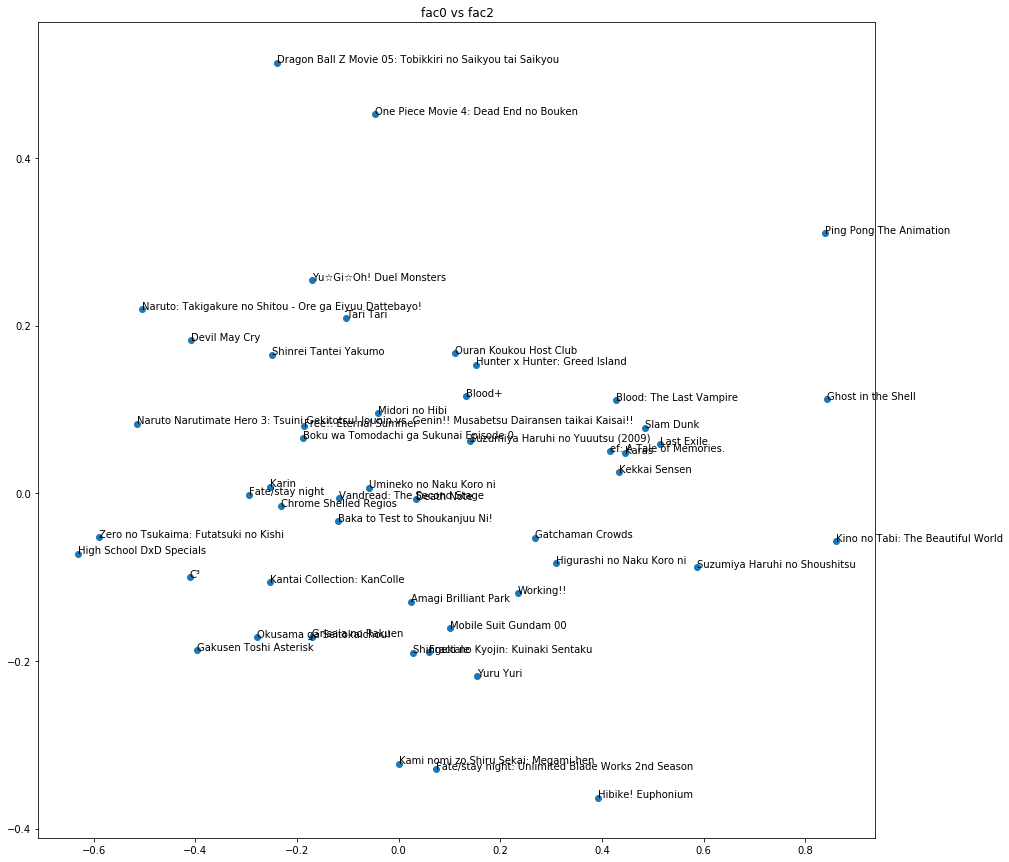

In [123]:
plot_relation(fac0, fac2, 'fac0 vs fac2')

In [124]:
ratings = np.array([mean_ratings.loc[i] for i in most_rated])

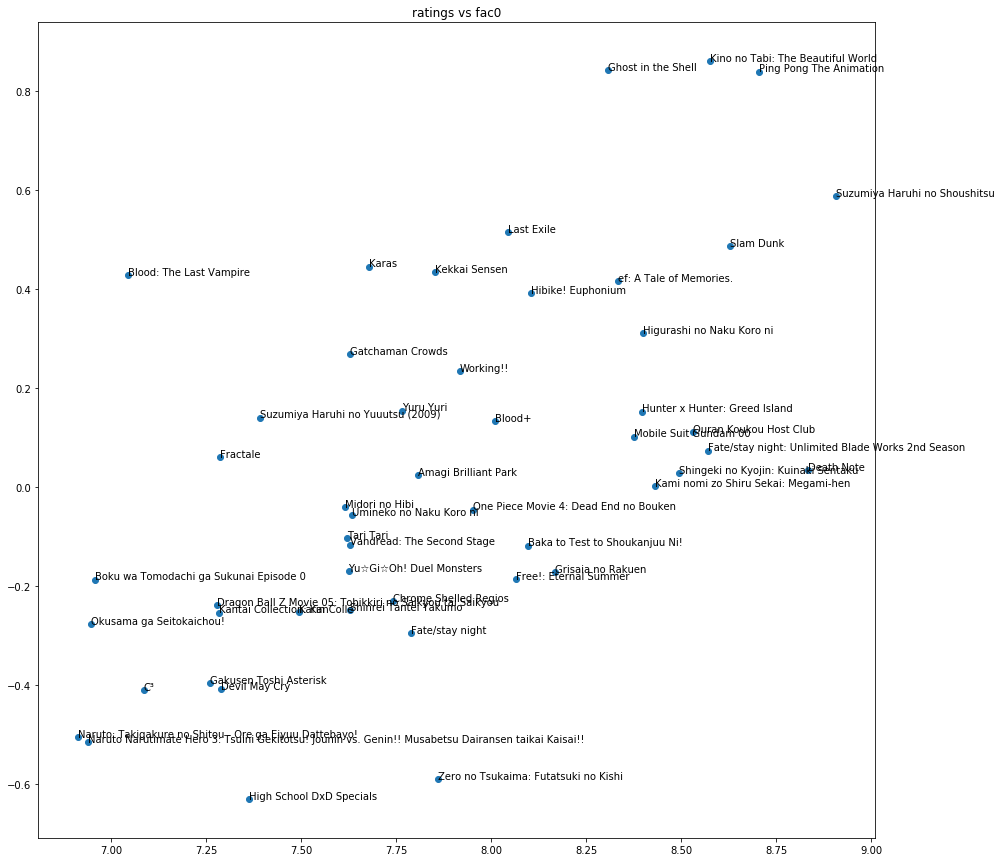

In [125]:
plot_relation(ratings, fac0, 'ratings vs fac0')

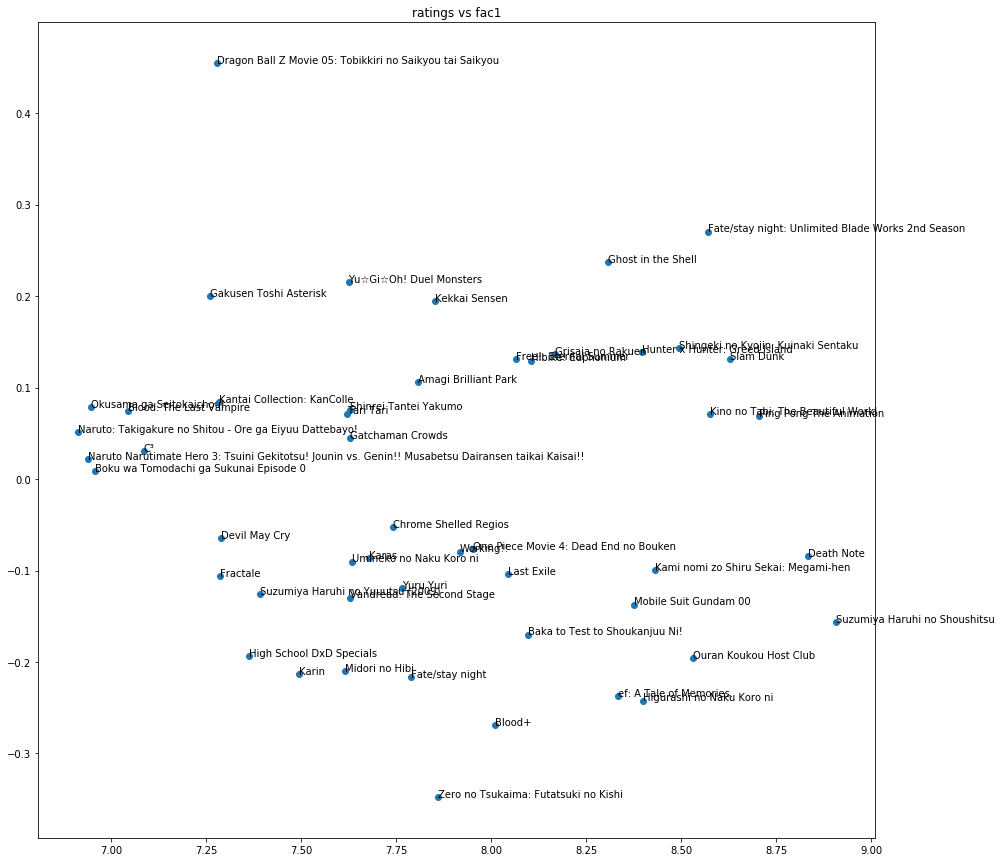

In [126]:
plot_relation(ratings, fac1, 'ratings vs fac1')

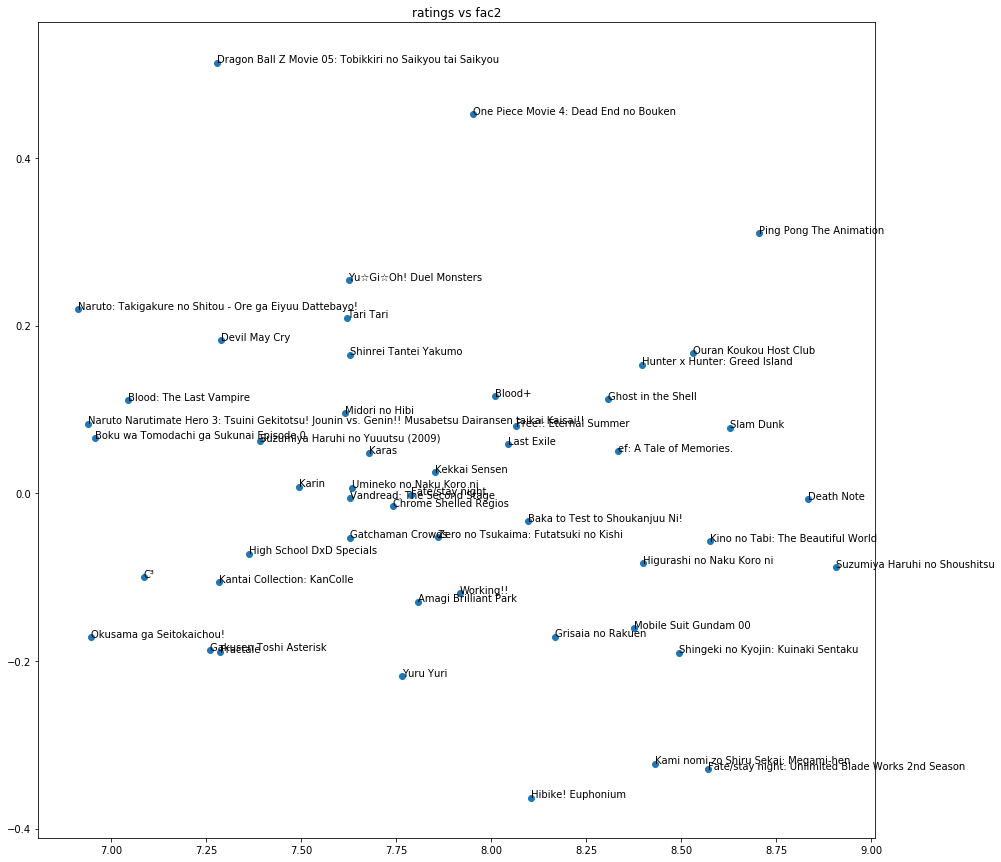

In [127]:
plot_relation(ratings, fac2, 'ratings vs fac2')